# Fourier Transform Function


In [6]:
from google.colab import drive
drive.mount('/content/MyDrive/')

Mounted at /content/MyDrive/


In [7]:
import numpy as np
import pylab as plt
import cmath as cm
from scipy.io import wavfile
import math
import time
from scipy.fftpack import fft
from functools import partial

In [8]:
# DESC: function that evaluates equation II for N real samples y_n for all k in the range 0 <= k <= N/2
# INPUTS: { y: list of sample points y_i /approx f(x) }
def dft(y):
  N = len(y)                                            # N: number of samples
  c = np.zeros(N//2+1, complex)                         # intialize c to a list of N/2 zeroes (because complex numbers come in conjugates)
  for k in range(N//2+1):                               # equation I
    for n in range(N):
      c[k] += y[n] * np.exp(-2j*np.pi*k*n/N)           
  return c

def audioReader(filename):
  # fs = sample rate
  # data = all samples (len(data) / fs = sample length)
  fs, data = wavfile.read(filename)
  #plt.plot(data.T[0])
  return fs, data.T[0] #we are going to just take the top channel

def freq_to_note(freq):
  if freq == 0:
      return 'Freq = 0'
  notes = ['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#']

  note_number = 12 * math.log2(freq / 440) + 49  
  note_number = round(note_number)
      
  note = (note_number - 1 ) % len(notes)
  note = notes[note]
  
  octave = (note_number + 8 ) // len(notes)
  
  return note, octave
  


In [9]:
def maxMinFinder(f, x1, x4, accuracy):
    z = (1 + math.sqrt(5))/2    # golden ratio
    x2 = x4 - (x4 - x1)/z  # interior point
    x3 = x1 + (x4 - x1)/z  # interior point
    
    steps = 0

    # Main loop of search
    while x4 - x1 > accuracy:
        steps += 1
        if f(x2) < f(x3):
            x4 = x3
            x3 = x2
            x2 = x4 - (x4 - x1)/z
        else:
            x1 = x2
            x2 = x3
            x3 = x1 + (x4 - x1)/z

    # Output results
    return (x1 + x4)/2

def noteFinderNew(xList, arrayIn, sound, printBool = False):
    maxNote, maxValue = 0, float('-inf') 

    ranges = [(100 * x, 100 * (x + 1)) for x  in range(36)]
    
    for lo, hi in ranges:
        root_freq = maxMinFinder(lambda x : -functionCreatorFromArray(xList, arrayIn, x), lo, hi, 0.1)
        value = functionCreatorFromArray(xList, arrayIn, root_freq)
        if (value > maxValue):
            maxValue = value
            maxNote = root_freq
        #print(f'The note found at range {lo}, {hi} was: {root_freq} with value: {value}')

    if printBool: print(f'Sound = {sound}')
    if printBool: print(f'Max note = {maxNote}, valueAtNote = {maxValue}')
    if printBool: print(f'Estimated Note: {freq_to_note(maxNote)}')
    if printBool: print()
    return maxNote, maxValue

def functionCreatorFromArray(xList, arrayIn, t):
    i = 0
    while xList[i] < t and i < len(xList):
        i += 1
    return arrayIn[i - 1]



In [10]:
def spectrumGrapher(filename, timeLength, fftFunc = dft, runtime = False, graph = False):
    start = time.time()
    fs, data = audioReader(filename)
    if runtime: print(f'After file read: {time.time() - start}')
    numberOfSamples = int(timeLength * fs)

    dftData = fftFunc(data[0:numberOfSamples])[0:numberOfSamples // 2 + 1]
    if runtime: print(f'After DFT: {time.time() - start}')

    xList = [x / timeLength for x in np.arange(0, numberOfSamples // 2 + 1, 1)]

    #normalization step of the original data
    maxFreq, maxValNormal = noteFinderNew(xList, abs(dftData), filename.split('/')[-1])

    normalizedInput = [x / maxValNormal for x in abs(dftData)]

    if runtime: print(f'After New Array / Max: {time.time() - start}')

    # eulers method on the data
    dt = 1
    RC = 3
    
    xEuler = 0
    xEulerList = [] 
    
    for vin in abs(dftData):
        xEulerList.append(xEuler)
        xEuler += dt*(1 / RC) * (vin - xEuler)
    
    #normalization of the euler method data
    maxFreq, maxVal = noteFinderNew(xList, xEulerList, filename.split('/')[-1])

    normalizedEuler = [x / maxValNormal for x in xEulerList]

    endTime = time.time() - start
    if runtime: print(f'End: {endTime}')
    if runtime: print()

    if(graph):
        plt.xlim(0, 4000)
        plt.plot(xList, normalizedInput, label = 'Normalized ' + filename.split('/')[-1])
        plt.plot(xList, normalizedEuler, label='Euler Method Data')
        plt.legend()
        plt.show()

    return xList, normalizedEuler, endTime
    

    

##### Testing

After file read: 0.2654547691345215
After DFT: 0.27382779121398926
After New Array / Max: 2.787419557571411
End: 3.78023624420166



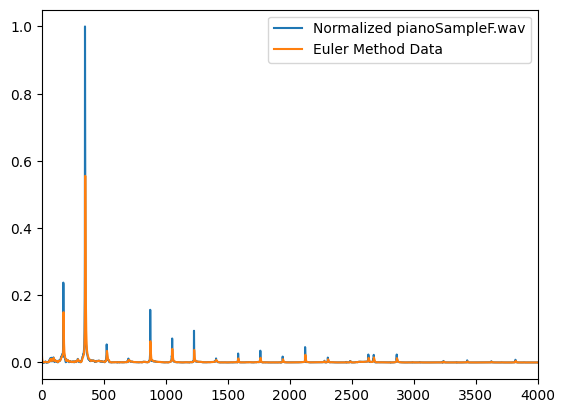

Sound = /content/MyDrive/MyDrive/physics_226_project/pianoSampleF.wav
Max note = 351.98199613804934, valueAtNote = 0.5554638365185306
Estimated Note: ('F', 4)



FileNotFoundError: ignored

In [11]:

xList, out, endTimeF = spectrumGrapher('/content/MyDrive/MyDrive/physics_226_project/pianoSampleF.wav', 1, fft, runtime = True, graph = True) 
noteFinderNew(xList, out, '/content/MyDrive/MyDrive/physics_226_project/pianoSampleF.wav', printBool = True)

xList, out, endTimeF = spectrumGrapher('bottleSound3.wav', 1, fft, runtime = True, graph = True) 
noteFinderNew(xList, out, 'bottleSound3.wav', printBool = True)

##### Runtime testing of different methods

[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]
[0.02628040313720703, 0.03879714012145996, 0.028824329376220703, 0.06440496444702148, 0.0440828800201416, 0.11959409713745117, 0.062489986419677734, 0.06971406936645508, 0.08085441589355469]


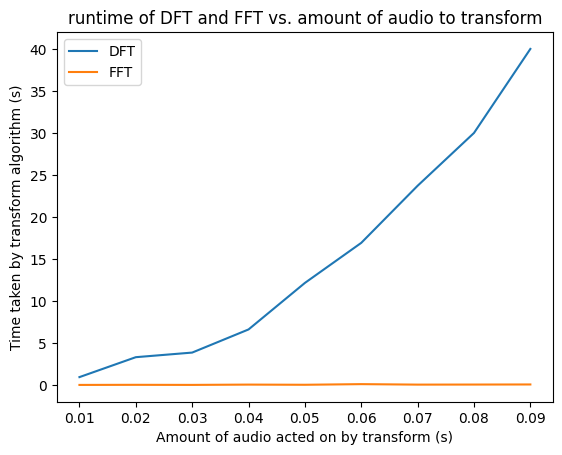

In [13]:
amt_audio = []
times_dft = []
times_fft = []

for i in range(1,10):
  amt_audio.append(i/100)
  piano_xList_dft, piano_out_dft, time_dft = spectrumGrapher('/content/MyDrive/MyDrive/physics_226_project/pianoSampleF.wav', i/100, dft, runtime = False)
  piano_xList_fft, piano_out_fft, time_fft = spectrumGrapher('/content/MyDrive/MyDrive/physics_226_project/pianoSampleF.wav', i/100, fft, runtime = False)

  times_dft.append(time_dft)
  times_fft.append(time_fft)

  noteFinderNew(piano_xList_dft, piano_out_dft, '/content/MyDrive/MyDrive/physics_226_project/pianoSampleF.wav')
  noteFinderNew(piano_xList_fft, piano_out_fft, '/content/MyDrive/MyDrive/physics_226_project/pianoSampleF.wav')

print(amt_audio)
print(times_fft)

plt.plot(amt_audio, times_dft, label='DFT')
plt.plot(amt_audio, times_fft, label='FFT')
plt.title('runtime of DFT and FFT vs. amount of audio to transform')
plt.xlabel('Amount of audio acted on by transform (s)')
plt.ylabel('Time taken by transform algorithm (s)')
plt.legend()
plt.show()
